# News Analysis with LLM (Gemini)

In [1]:
import os
from dotenv import load_dotenv

load_dotenv("secret.env")

api_key = os.getenv("GEMINI_API_KEY")

if api_key is None:
    print("Error: GEMINI_API_KEY not found in .env file or environment variables.")
else:
    print("GEMINI_API_KEY loaded successfully.")

GEMINI_API_KEY loaded successfully.


In [4]:
import google.generativeai as genai
from tqdm import tqdm

genai.configure(api_key=api_key)
generation_config = genai.GenerationConfig(
        temperature=0,
)
model = genai.GenerativeModel("gemini-2.5-flash-preview-04-17", generation_config=generation_config)

In [5]:
from google.api_core import retry

# Catch transient Gemini errors.
def is_retryable(e) -> bool:
    if retry.if_transient_error(e):
        # Good practice, but probably won't fire with the google-genai SDK
        return True
    elif (isinstance(e, genai.errors.ClientError) and e.code == 429):
        # Catch 429 quota exceeded errors
        return True
    elif (isinstance(e, genai.errors.ServerError) and e.code == 503):
        # Catch 503 model overloaded errors
        return True
    else:
        return False

@retry.Retry(predicate=is_retryable)
def generate_content_with_rate_limit(prompt):
  return model.generate_content(prompt).text

In [6]:
prompt = """You are a financial news analyst specializing in stock market impact. Your task is to analyze the provided news article, summarize its core content concisely, determine its sentiment (positive, negative, or neutral), and assess its importance to the specified stock.

Here is the news from stock [STOCK] title and body:
---
[TITLE]
---
[BODY]
---

Please provide your analysis in the following format:

**Sentiment:**
[Positive / Negative / Neutral]

**Summary:**
[Your concise summary of the article, typically 2-3 sentences.]

**Reasoning for Sentiment:**
[Brief explanation (1-2 sentences) of why you categorized the sentiment as such, referencing key points or tone from the article.]

**Importance to Stock [STOCK]:**
[1-5, where 1 is minimal importance and 5 is very high importance.Answer in 1-5 only, no explanation.]

**Reasoning for Importance:**
[Brief explanation (1-2 sentences) of why you assigned this importance score, referencing specific details from the article that would impact the stock.]"""

In [7]:
import pandas as pd
import numpy as np

In [61]:
df = pd.read_csv("../../DataCollection/Data/News/SPX_2025-05-27_00-03-22.csv")
display(df.head())

,ticker,publish_date,publish_time,title,body_text,url
0,SPX,2025-05-26,07:12,JPMorgan Announces Cash Distributions for the ...,"TORONTO, May 26, 2025 (GLOBE NEWSWIRE) -- J.P....",https://www.investing.com/news/press-releases/...
1,SPX,2025-05-26,06:25,Is this a turning point for markets? By Invest...,Investing.com -- Despite a turbulent start to ...,https://www.investing.com/news/stock-market-ne...
2,SPX,2025-05-26,02:31,Take Five: Chips and trouble in bond land By R...,(Reuters) -Chip behemoth Nvidia (NASDAQ: ) is ...,https://www.investing.com/news/economy-news/ta...
3,SPX,2025-05-25,22:40,Asia stocks mixed amid Trump tariff uncertaint...,Investing.com-- Most Asian markets were a mixe...,https://www.investing.com/news/stock-market-ne...
4,SPX,2025-05-25,20:41,US stock futures jump as Trump agrees to postp...,Investing.com-- U.S. stock index futures rose ...,https://www.investing.com/news/stock-market-ne...


In [27]:
df.isnull().sum()

ticker          0
publish_date    0
publish_time    0
title           0
body_text       0
url             0
dtype: int64

In [28]:
df["title"] = df["title"].astype(str)
df["body_text"] = df["body_text"].astype(str)

In [29]:
print(df.head())

  ticker publish_date publish_time  \
0    SPX   2025-05-26        07:12   
1    SPX   2025-05-26        06:25   
2    SPX   2025-05-26        02:31   
3    SPX   2025-05-25        22:40   
4    SPX   2025-05-25        20:41   

                                               title  \
0  JPMorgan Announces Cash Distributions for the ...   
1  Is this a turning point for markets? By Invest...   
2  Take Five: Chips and trouble in bond land By R...   
3  Asia stocks mixed amid Trump tariff uncertaint...   
4  US stock futures jump as Trump agrees to postp...   

                                           body_text  \
0  TORONTO, May 26, 2025 (GLOBE NEWSWIRE) -- J.P....   
1  Investing.com -- Despite a turbulent start to ...   
2  (Reuters) -Chip behemoth Nvidia (NASDAQ: ) is ...   
3  Investing.com-- Most Asian markets were a mixe...   
4  Investing.com-- U.S. stock index futures rose ...   

                                                 url  
0  https://www.investing.com/news/press-re

In [30]:
predicted = []

for index, row in tqdm(df.iterrows(), total=len(df), desc="Prompting"): 
    current_stock = row.get("ticker", "Unknown Stock")

    filled_prompt = prompt.replace("[STOCK]", current_stock)
    filled_prompt = filled_prompt.replace("[TITLE]", row["title"])
    filled_prompt = filled_prompt.replace("[BODY]", row["body_text"])

    try:
        response = generate_content_with_rate_limit(filled_prompt)
        finalprediction = response.strip()
        if not finalprediction:
            print(f"Row {index}: LLM returned an empty string.")
            predicted.append("LLM_EMPTY_RESPONSE")
        else:
            predicted.append(finalprediction)
    except ValueError as ve:
        print(f"Row {index}: ValueError - {ve}. Appending 'ERROR_VALUE_ERROR'.")
        predicted.append("ERROR_VALUE_ERROR")
        continue
    except Exception as e:
        if "429 Too Many Requests" in str(e) or "quota" in str(e).lower():
            print(f"Row {index}: Rate Limit Exceeded or Quota Error - {e}. Appending 'ERROR_RATE_LIMIT'.")
            predicted.append("ERROR_RATE_LIMIT")
        elif "safety" in str(e).lower() or "blocked" in str(e).lower():
             print(f"Row {index}: Content Safety/Blocked - {e}. Appending 'ERROR_SAFETY_BLOCKED'.")
             predicted.append("ERROR_SAFETY_BLOCKED")
        else:
            print(f"Row {index}: Unexpected Error - {e}. Appending 'ERROR_UNEXPECTED'.")
            predicted.append("ERROR_UNEXPECTED")
        continue

Prompting: 100%|██████████| 20/20 [01:55<00:00,  5.77s/it]


In [62]:
predicted = np.array(predicted)
df["predicted"] = predicted

In [63]:
print(df["title"][2],'\n\n',predicted[2])

Take Five: Chips and trouble in bond land By Reuters 

 **Sentiment:**
Neutral

**Summary:**
The article previews key market events for the week, focusing on Nvidia's earnings report as a test for the recent stock market rebound and highlighting rising volatility and yields in long-term government bonds due to debt concerns. It also covers upcoming global inflation data and central bank meetings that will influence monetary policy expectations.

**Reasoning for Sentiment:**
The article presents a balanced preview of upcoming market drivers and potential pressure points, discussing both the recent market rebound and significant risks like bond market stress and inflation concerns, without taking a definitive bullish or bearish stance.

**Importance to Stock SPX:**
5

**Reasoning for Importance:**
The article discusses major factors directly impacting the S&P 500, including the earnings of a key index component (Nvidia), US bond market dynamics, US inflation data, and investor sentiment 

In [64]:
df["sentiment"] = df["predicted"].apply(lambda x: x.split("\n")[1].strip() if len(x.split("\n")) > 1 else None)
df["importance"] = df["predicted"].apply(lambda x: x.split("\n")[10].strip() if len(x.split("\n")) > 10 else None)
df["summary"] = df["predicted"].apply(lambda x: x.split("\n")[4].strip() if len(x.split("\n")) > 4 else None)

In [65]:
df[df["importance"]== "5"][["publish_date","title", "sentiment","importance", "summary"]]

,publish_date,title,sentiment,importance,summary
1,2025-05-26,Is this a turning point for markets? By Invest...,Neutral,5,The article notes the market's resilience in e...
2,2025-05-26,Take Five: Chips and trouble in bond land By R...,Neutral,5,The article previews key market events for the...
3,2025-05-25,Asia stocks mixed amid Trump tariff uncertaint...,Neutral,5,Asian markets showed mixed reactions to U.S. P...
4,2025-05-25,US stock futures jump as Trump agrees to postp...,Positive,5,US stock index futures rose sharply after Pres...
6,2025-05-25,"Nvidia earnings in focus as rising US yields, ...",Negative,5,The article highlights market concerns driven ...
7,2025-05-25,Is a U.S. government debt crisis imminent? By ...,Negative,5,The article highlights escalating concerns abo...
10,2025-05-23,Trading Day: Trump shatters tariff calm with n...,Negative,5,President Trump's new threats of tariffs on Eu...
11,2025-05-23,U.S. stocks lower at close of trade; Dow Jones...,Negative,5,"U.S. stocks closed lower on Friday, with all m..."
13,2025-05-23,TSX closes mixed amid more Trump trade turmoil...,Negative,5,Canada's main stock index closed mixed/slightl...
15,2025-05-23,"Nvidia earnings in focus as rising US yields, ...",Negative,5,The article highlights market concerns over ri...


In [66]:
display(df[df['sentiment']==''])
df = df[df['sentiment'] != '']

,ticker,publish_date,publish_time,title,body_text,url,predicted,sentiment,importance,summary


In [ ]:
df = df[df['sentiment'].isin(['Positive', 'Negative', 'Neutral'])]
df = df[df['importance'].isin(['1', '2', '3', '4', '5'])]

<Axes: title={'center': 'Sentiment Distribution'}, xlabel='sentiment'>

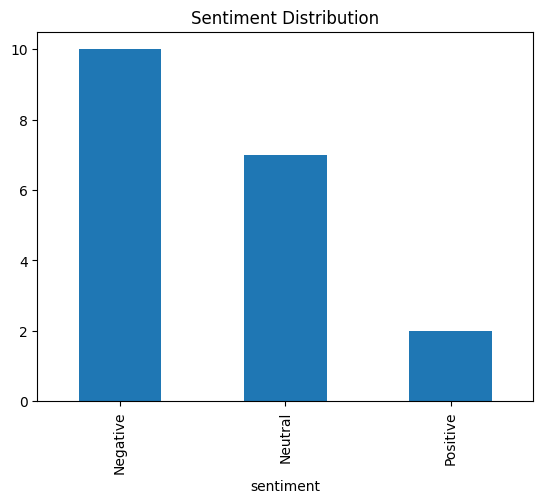

In [68]:
df['sentiment'].value_counts().plot(kind='bar', title='Sentiment Distribution')

<Axes: title={'center': 'Importance Distribution'}, xlabel='importance'>

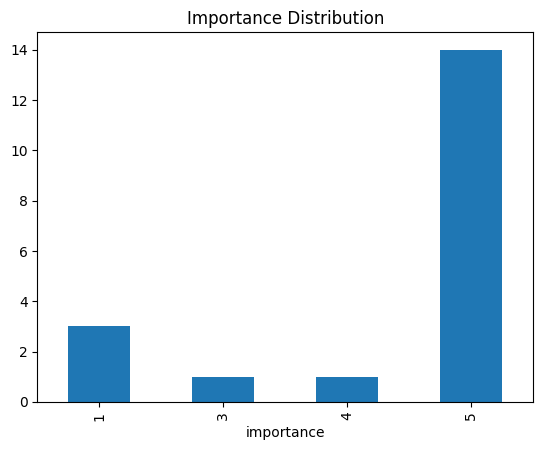

In [69]:
df['importance'].value_counts().sort_index().plot(kind='bar', title='Importance Distribution')

In [70]:
TICKER=df["ticker"][0]

In [71]:
df[df['sentiment']=='']
df = df[df['sentiment'] != '']

In [72]:
def calculate_sentiment_score(df):
    sentiment_scores = {
        'Positive': 1,
        'Negative': -1,
        'Neutral': 0
    }
    
    df['sentiment_score'] = df['sentiment'].map(sentiment_scores)
    
    df['weighted_score'] = df['sentiment_score'] * df['importance'].astype(int)
    
    total_importance = df['importance'].astype(int).sum()
    
    if total_importance == 0:
        return 0
    
    sentiment_score = df['weighted_score'].sum() / total_importance
    return sentiment_score

In [73]:
print(f"Sentiment Score for {TICKER}: {calculate_sentiment_score(df).round(2)}")

Sentiment Score for SPX: -0.55


In [74]:
import datetime

df.drop(columns=['predicted','body_text'],inplace=True)
now = datetime.datetime.now()
date_time = now.strftime("%Y-%m-%d %H-%M-%S").strip().replace(' ', '_')
df.to_csv(f"Output/Gemini_{TICKER}_{date_time}.csv", index=False)